In [1]:
from math import sqrt, ceil
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv('../data/student-por.csv')

In [3]:
# This cell is used to convert the categorical data to numerical data, and write it back to the csv file
# Thus, It only has to be run once
# from sklearn.preprocessing import LabelEncoder

# stander_scaler = LabelEncoder()
# data['sex'] = stander_scaler.fit_transform(data['sex'])
# data['school'] = stander_scaler.fit_transform(data['school'])
# data['address'] = stander_scaler.fit_transform(data['address'])
# data['famsize'] = stander_scaler.fit_transform(data['famsize'])
# data['Pstatus'] = stander_scaler.fit_transform(data['Pstatus'])
# data['Mjob'] = stander_scaler.fit_transform(data['Mjob'])
# data['Fjob'] = stander_scaler.fit_transform(data['Fjob'])
# data['reason'] = stander_scaler.fit_transform(data['reason'])
# data['guardian'] = stander_scaler.fit_transform(data['guardian'])
# data['schoolsup'] = stander_scaler.fit_transform(data['schoolsup'])
# data['famsup'] = stander_scaler.fit_transform(data['famsup'])
# data['paid'] = stander_scaler.fit_transform(data['paid'])
# data['activities'] = stander_scaler.fit_transform(data['activities'])
# data['nursery'] = stander_scaler.fit_transform(data['nursery'])
# data['higher'] = stander_scaler.fit_transform(data['higher'])
# data['internet'] = stander_scaler.fit_transform(data['internet'])
# data['romantic'] = stander_scaler.fit_transform(data['romantic'])

# write it back to the csv file
# data.to_csv('../data/student-por.csv', index=False)

In [4]:
Y = data[['G1', 'G2', 'G3']].sum(axis=1)
X = data.drop(['G1', 'G2', 'G3'], axis=1)
Y = Y.apply(lambda x: 1 if x > 36 else 0)

In [5]:
random_state = 9527

pca_1d = PCA(5, random_state=random_state)
L_sk = pca_1d.fit_transform(X)
print('L_sk.shape:', L_sk.shape)
print('L_sk:', L_sk[:, :4])


L_sk.shape: (649, 5)
L_sk: [[ 0.30496353 -0.27002464 -0.83606091  0.36187049]
 [-1.77714874  2.67705741 -1.10328362 -0.5268237 ]
 [ 2.26409563  1.98388544 -0.71914165  0.12464743]
 ...
 [ 2.26323333  2.08418604 -1.77640727 -2.65372224]
 [ 2.57562727  0.23117274  2.21383997  2.34036755]
 [ 0.46668598 -0.14984225  2.01225714 -1.38267225]]


In [6]:
print(Y.value_counts())

0    373
1    276
Name: count, dtype: int64


In [7]:
def knn_thing(L_sk, Y, log_data, ratio=.2, rs=42):
    curr_best_report = None
    curr_best_k = None
    best_f1 = 0
    for i in range(1, ceil(sqrt(len(L_sk)))):
        X_train, X_test, y_train, y_test = train_test_split(L_sk, Y, test_size=ratio, random_state=rs)
        # Feature scaling (optional but recommended for KNN)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        knn = KNeighborsClassifier(n_neighbors=i)

        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            curr_best_report = classification_report(y_test, y_pred)
            curr_best_k = i
        log_data.append({'k': i, 'F1 Score': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})

    log_df = pd.DataFrame(log_data)
    curr_time = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')
    log_df.to_csv(f'../reports/pca_then_knn_{curr_time}.csv', index=False)
    print(f"Best K: {curr_best_k}")
    print(curr_best_report)

In [8]:
def plot_log(log_df, title='Performance Metrics vs. k(With PCA)'):
    plt.figure(figsize=(10, 6))
    plt.plot(log_df['k'], log_df['F1 Score'], label='F1 Score')
    plt.plot(log_df['k'], log_df['Accuracy'], label='Accuracy')
    plt.plot(log_df['k'], log_df['Precision'], label='Precision')
    plt.plot(log_df['k'], log_df['Recall'], label='Recall')

    plt.xlabel('k')
    plt.ylabel('value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Best K: 14
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        70
           1       0.67      0.68      0.68        60

    accuracy                           0.70       130
   macro avg       0.70      0.70      0.70       130
weighted avg       0.70      0.70      0.70       130


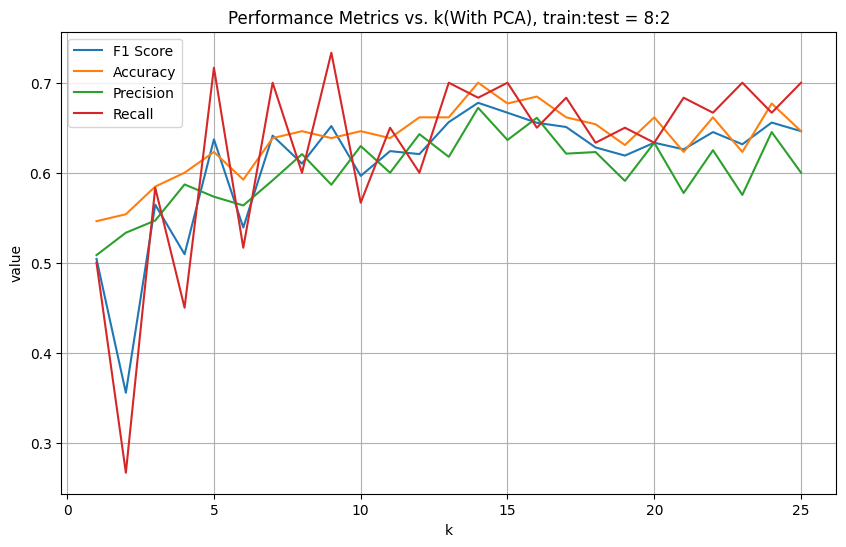

In [9]:
## KNN with train:test = 8:2
log_data = []
knn_thing(L_sk, Y, log_data)
plot_log(pd.DataFrame(log_data), title='Performance Metrics vs. k(With PCA), train:test = 8:2')

Best K: 25
              precision    recall  f1-score   support

           0       0.75      0.69      0.72       110
           1       0.64      0.71      0.67        85

    accuracy                           0.70       195
   macro avg       0.70      0.70      0.70       195
weighted avg       0.70      0.70      0.70       195


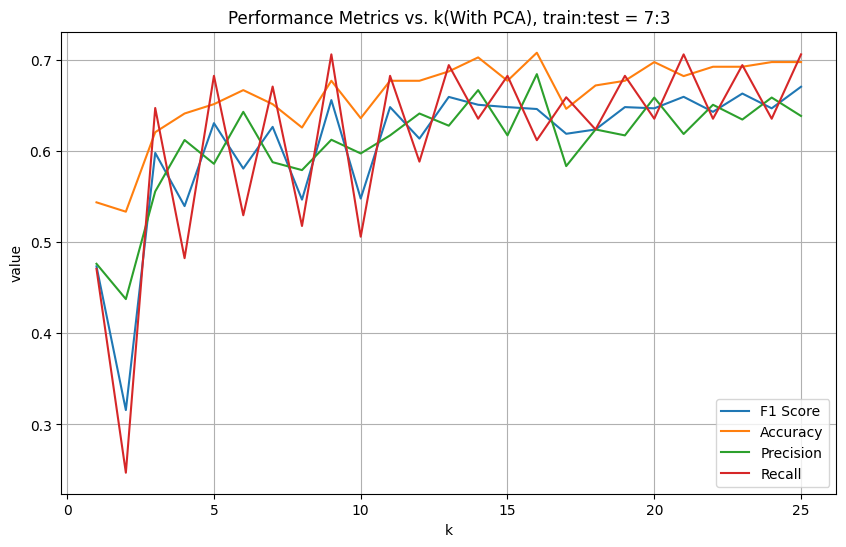

In [10]:
## KNN with train:test = 7:3
log_data = []
knn_thing(L_sk, Y, log_data, ratio=.3)
plot_log(pd.DataFrame(log_data), title='Performance Metrics vs. k(With PCA), train:test = 7:3')